In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split

import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from joblib import Parallel, delayed

In [2]:
# data_path = "..\Training Data\MindBigData\MindBigData-Imagenet-IN\MindBigData-Imagenet"
# paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]
# min_samples = 384

# def extract_samples(path):
#     df = pd.read_csv(path, index_col=0, header=None).T
#     return df.shape[0]

# samples = Parallel(n_jobs=-1)(delayed(extract_samples)(path) for path in paths)
# min_number_of_samples = min(samples)
min_number_of_samples = 360

In [3]:
# data_path = "..\Training Data\MindBigData\MindBigData-Imagenet-IN\MindBigData-Imagenet"
# paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]
# X_train, X_test, _, _ = train_test_split(paths, paths, test_size=0.2, shuffle=True)

# for file in os.listdir("..\Training Data\BrainVis_Preprocessing\eegs\\test"):
#     os.remove(os.path.join("..\Training Data\BrainVis_Preprocessing\eegs\\test", file))

# for file in os.listdir("..\Training Data\BrainVis_Preprocessing\eegs\\train"):
#     os.remove(os.path.join("..\Training Data\BrainVis_Preprocessing\eegs\\train", file))

# for path in X_test:
#     example_path = str(path)
#     segments = example_path.split("\\")
#     file_name = segments[-1]
#     shutil.copyfile(path, os.path.join("..\Training Data\BrainVis_Preprocessing\eegs\\test", file_name))
    
# for path in X_train:
#     example_path = str(path)
#     segments = example_path.split("\\")
#     file_name = segments[-1]
#     shutil.copyfile(path, os.path.join("..\Training Data\BrainVis_Preprocessing\eegs\\train", file_name))

In [5]:
class EEG_DataSet(Dataset):
    def __init__(self, eegs_dir, transform=None, target_transform=None):
        self.eegs_dir = eegs_dir
        self.eeg_examples = Parallel(n_jobs=-1)(delayed(EEG_DataSet.extract_sample)(os.path.join(eegs_dir, path)) for path in os.listdir(eegs_dir))
        self.transform = transform
        self.target_transform = target_transform

    @classmethod    
    def extract_sample(cls, sample_path):
        eeg_df = pd.read_csv(sample_path, index_col=0, header=None).T
        eeg_npArray = np.array(eeg_df, dtype=np.float32)[:min_number_of_samples].reshape(5,min_number_of_samples,1)
        return (eeg_npArray, eeg_df)

    def __len__(self):
        return len(self.eeg_examples)

    def __getitem__(self, idx):
        eeg_npArray, _ = self.eeg_examples[idx]
        if self.transform: eeg_npArray = self.transform(eeg_npArray)
        if self.target_transform: eeg_npArray = self.target_transform(eeg_npArray)
        return eeg_npArray, eeg_npArray

train_dataset = EEG_DataSet("..\Training Data\BrainVis_Preprocessing\eegs\\train",)
test_dataset = EEG_DataSet("..\Training Data\BrainVis_Preprocessing\eegs\\test",)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 15, kernel_size=3, stride=1, padding=1, groups=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(15, 30, kernel_size=3, stride=1, padding=1, groups=15),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(30, 15, kernel_size=3, stride=2, padding=1, output_padding=(0, 0)),
            nn.ReLU(),
            nn.ConvTranspose2d(15, 5, kernel_size=3, stride=2, padding=(2,1), output_padding=(1, 0)),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
model = Autoencoder()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 200
losses = []
for epoch in range(num_epochs):
    batch_loss = []
    for data in train_loader:
        eeg, _ = data
        eeg = eeg.to(device)
        optimizer.zero_grad()
        output = model(eeg)
        loss = criterion(output, eeg)
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())
    losses.append(np.mean(batch_loss))

    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
 
# Save the model
torch.save(model.state_dict(), 'conv_autoencoder.pth')

cuda
Epoch [1/200], Loss: 17965790.0000
Epoch [6/200], Loss: 18009994.0000
Epoch [11/200], Loss: 18028422.0000
Epoch [16/200], Loss: 18015746.0000
Epoch [21/200], Loss: 17954874.0000
Epoch [26/200], Loss: 18040458.0000
Epoch [31/200], Loss: 18068970.0000
Epoch [36/200], Loss: 18395734.0000
Epoch [41/200], Loss: 17996760.0000
Epoch [46/200], Loss: 18045944.0000
Epoch [51/200], Loss: 18060538.0000
Epoch [56/200], Loss: 18060492.0000
Epoch [61/200], Loss: 18013346.0000
Epoch [66/200], Loss: 18016188.0000
Epoch [71/200], Loss: 18025528.0000
Epoch [76/200], Loss: 17957746.0000
Epoch [81/200], Loss: 18124726.0000
Epoch [86/200], Loss: 18021530.0000
Epoch [91/200], Loss: 18047632.0000
Epoch [96/200], Loss: 18089910.0000
Epoch [101/200], Loss: 18027094.0000
Epoch [106/200], Loss: 17998792.0000
Epoch [111/200], Loss: 17979418.0000
Epoch [116/200], Loss: 18072270.0000
Epoch [121/200], Loss: 17992608.0000
Epoch [126/200], Loss: 18012998.0000
Epoch [131/200], Loss: 18028146.0000
Epoch [136/200], L

In [10]:
test_loss = []
for data in test_loader:
    eeg, _ = data
    eeg = eeg.to(device)
    output = model(eeg)
    loss = criterion(output, eeg)

    test_loss.append(loss.item())

print(f"Average testing loss: {round(np.mean(test_loss), 4)}")

Average testing loss: 18041842.5455


Text(0.5, 1.0, 'Training Loss over 200 epochs')

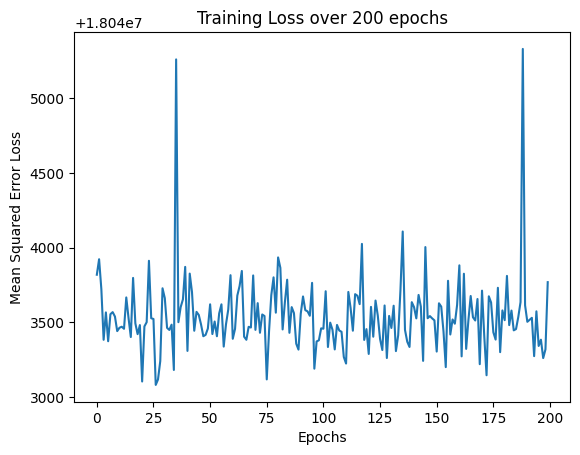

In [11]:
plt.plot(losses)
plt.ylabel("Mean Squared Error Loss")
plt.xlabel("Epochs")
plt.title(f"Training Loss over {num_epochs} epochs")

Text(0.5, 1.0, 'Sample EEG')

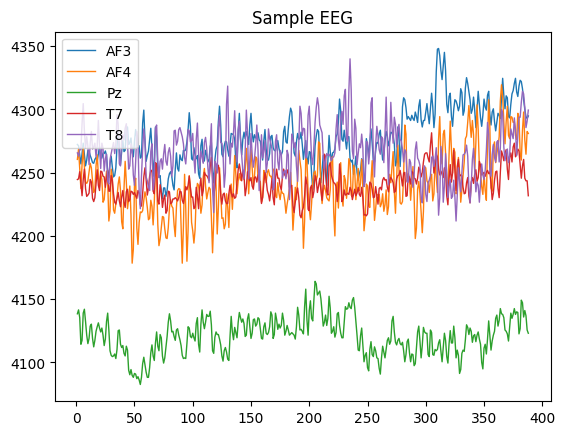

In [12]:
data_path = "..\Training Data\MindBigData\MindBigData-Imagenet-IN\MindBigData-Imagenet"
paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]

df = pd.read_csv(paths[0], index_col=0, header=None).T

for channel in ["AF3", "AF4", "Pz", "T7", "T8"]:
    plt.plot(df[channel], label=channel, linewidth=1)
plt.legend()
plt.title("Sample EEG")